# REDUCED SET

In [ ]:
from template_csp import managetemp as mte
import numpy as np
import pandas as pd
import random
from template_csp.distances import dist1, dist2, dist3

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1,
    "lev_red" : 0.135
}
comp = 1
df = pd.read_csv(f'A{comp}B/relaxation/RELAX_DATA', sep=",", index_col=0, na_filter = False)
test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

template_set = mte.TemplateSet(test_elements, 'RANDOM/FULL50sets/20/TemplateSet_1')
pairset = mte.PairSet(template_set, test_elements, dist2, 'RANDOM/FULL50sets/20/PairSet_1', )
reducted_set = pairset.reduced_set(hyperparameters)
subset_templates = [f'{template_set.couples[i][0][0]}{template_set.couples[i][0][1]}_{template_set.couples[i][1]}' for i in reducted_set]
n_temp_test = len(subset_templates)

pmatrix = {}
couples = np.array([])

for i in range(len(test_elements)):
    for j in range(i+1,len(test_elements)):
        couple = [test_elements[i],test_elements[j]]
        couple.sort()
        couple = ''.join(couple)
        pvec = np.zeros((2, len(subset_templates)))

        for idx, template in enumerate(subset_templates):
            pvec[0,idx] = df.loc[couple,template]
            pvec[1,idx] = idx
        
        sorted_idx = np.argsort(pvec[0])
        pvec[0] = pvec[0][sorted_idx]
        pvec[1] = pvec[1][sorted_idx]

        pmatrix[couple] = pvec
        couples = np.append(couples, couple)

lev_dist_matrix = np.zeros((len(couples), len(couples)))

for row, couple1 in enumerate(couples):
    for col, couple2 in enumerate(couples):
        if row == col:
            lev_dist_matrix[row,col] = 0
        else:
            lev_dist_matrix[row,col] = dist2(pmatrix[couple1], pmatrix[couple2]) 
print(len(subset_templates))
print(lev_dist_matrix.mean())

In [ ]:
df_entforma = pd.read_csv(f'A{comp}B/relaxation/OneElementEnt.txt', sep=",", index_col=0, na_filter = False, header=None)
import re
couple = 'NaAl'
A = re.findall(r'[A-Z][a-z]*', couple)[0]
B = re.findall(r'[A-Z][a-z]*', couple)[1]

ent_form = ent_form/2
print(ent_form)


In [10]:
from template_csp import managetemp as mte
import numpy as np
import pandas as pd
import random
from template_csp.distances import dist1, dist2, dist3
import re

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1,
    "lev_red" : 0.05
}
comp = 1
df = pd.read_csv(f'A{comp}B/relaxation/RELAX_DATA', sep=",", index_col=0, na_filter = False)
df_entforma = pd.read_csv(f'A{comp}B/relaxation/OneElementEnt.txt', sep=",", index_col=0, na_filter = False, header=None)
test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

template_set = mte.TemplateSet(test_elements, 'RANDOM/FULL50sets/20/TemplateSet_1')
pairset = mte.PairSet(template_set, test_elements, dist_function=dist2, relaxed_pairs='RANDOM/FULL50sets/20/PairSet_1', )
reducted_set = pairset.reduced_set(hyperparameters)

subset_templates = [f'{template_set.couples[i][0][0]}{template_set.couples[i][0][1]}_{template_set.couples[i][1]}' for i in reducted_set]
n_temp_test = len(subset_templates)
print(len(subset_templates))
gs_temp = {}
couples = np.array([])

for i in range(len(test_elements)):
    for j in range(i+1,len(test_elements)):
        couple = [test_elements[i],test_elements[j]]
        couple.sort()
        couple = ''.join(couple)
        pvec = np.zeros((2, len(subset_templates)))

        for idx, template in enumerate(subset_templates):
            pvec[0,idx] = df.loc[couple,template]
            pvec[1,idx] = idx
        
        sorted_idx = np.argsort(pvec[0])
        pvec[0] = pvec[0][sorted_idx]
        pvec[1] = pvec[1][sorted_idx]

        gs_temp[couple] = subset_templates[int(pvec[1][0])]
        couples = np.append(couples, couple)

pmatrix = {}
for template in subset_templates:
    pvec = np.zeros((2, len(couples)))
    for idx, couple in enumerate(pairset.couples):
        A = couple[0]#re.findall(r'[A-Z][a-z]*', couple)[0]
        B = couple[1]#re.findall(r'[A-Z][a-z]*', couple)[1]
        ent_form = (df_entforma.loc[A,1] + df_entforma.loc[B,1])/2
        pvec[0,idx] = df.loc[A+B,template] - ent_form
        pvec[1,idx] = idx
    pmatrix[template] = pvec

lev_dist_matrix = np.zeros((len(couples), len(couples)))
for couple in couples:
    for couple2 in couples:
        row = np.where(couples == couple)[0][0]
        col = np.where(couples == couple2)[0][0]
        lev_dist_matrix[row, col] = dist2(pmatrix[gs_temp[couple]], pmatrix[gs_temp[couple2]])
 


8


In [14]:
np.savetxt('CLUSTERS/ClustersDict/DistMatrix', lev_dist_matrix)

# DENDOGRAM

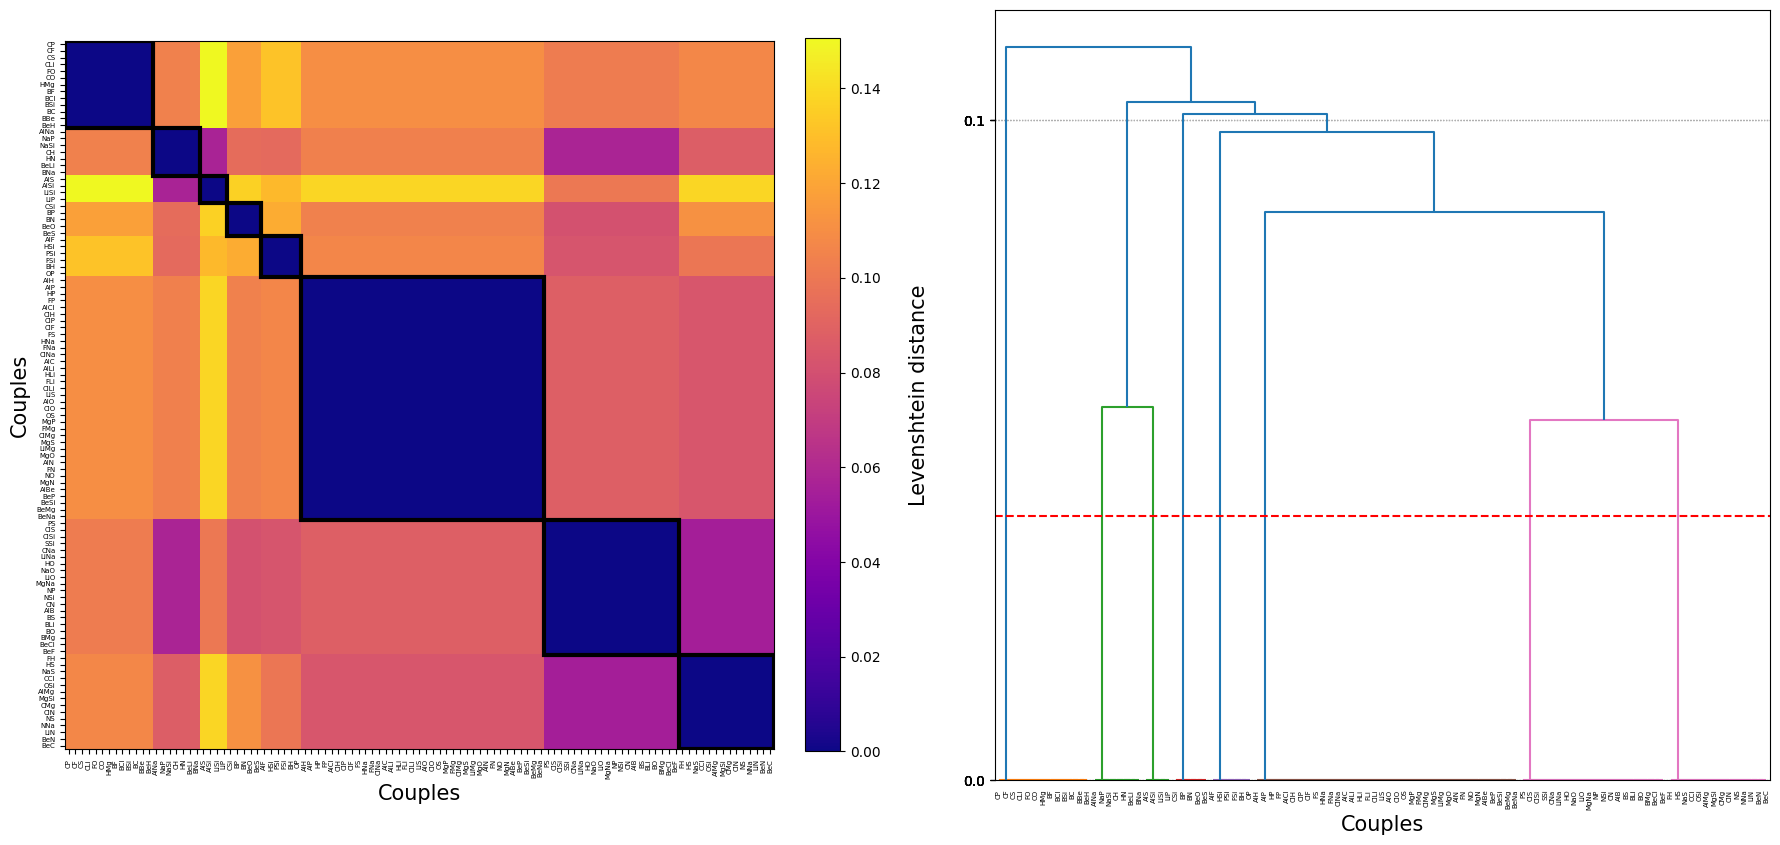

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.patches as patches
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={"width_ratios": [3, 3]})

condensed_dist_matrix = squareform(lev_dist_matrix)
Z = linkage(condensed_dist_matrix, method='average')
dendro = dendrogram(Z ,labels = couples, leaf_rotation=90, leaf_font_size=5, ax=ax1)
sorted_idx = dendro['leaves']
threshold = 0.03
desired_clusters = 8
num_clusters = np.inf
while num_clusters > desired_clusters:
    threshold += 0.01
    cluster_labels = fcluster(Z, t=threshold, criterion="distance")
    num_clusters = len(np.unique(cluster_labels)) 


new = lev_dist_matrix[sorted_idx, :][:, sorted_idx]
cluster_labels_sorted = cluster_labels[sorted_idx]

im = ax.imshow(new, cmap='plasma') #or Spectral
#im.set_clim((n_temp_test+1)/4, (n_temp_test+1)/2)

couples_in_clusters = []

unique_clusters = np.unique(cluster_labels_sorted)
for cluster in unique_clusters:
    # Trova gli indici che appartengono a questo cluster
    cluster_indices = np.where(cluster_labels_sorted == cluster)[0]
    if len(cluster_indices) > 0:
        # Trova il primo e l'ultimo elemento del cluster per i bordi
        start, end = cluster_indices[0], cluster_indices[-1]
        cluster_size = end - start + 1
        couples_in_clusters.append(np.array(couples)[sorted_idx][start:end+1])

        # Aggiungi un rettangolo per evidenziare il cluster con un piccolo offset
        rect = patches.Rectangle((start - 0.5, start - 0.5), cluster_size, cluster_size,
                                 linewidth=3, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

# Imposta i tick e mostra la figura
ax.set_xticks(np.arange(len(couples)))
ax.set_yticks(np.arange(len(couples)))
ax.set_xticklabels(np.array(couples)[sorted_idx], fontsize=5, rotation=90)
ax.set_yticklabels(np.array(couples)[sorted_idx], fontsize=5)  
ax.set_xlabel('Couples', fontsize=15)
ax.set_ylabel('Couples', fontsize=15)

fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)


ax1.axhline(y=threshold, color='r', linestyle='--')
ax1.set_ylabel('Levenshtein distance', fontsize=15)
ax1.set_xlabel('Couples', fontsize=15)
ax1.yaxis.set_label_coords(-0.085, 0.5)
yticks = np.linspace(0, 0.13, 10)   
yticks = np.round(yticks, decimals=1)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=10)
ax1.grid(True, ls=':', axis='y')
plt.show()


# PIE CHART

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
total_hist = {}
hist = {}
len_cluster = []
for idx_cluster, cluster in enumerate(couples_in_clusters):
    if len(cluster) == 1:
        continue
    hist[f'{idx_cluster}'] = {}
    len_cluster.append(len(cluster))
    for i in cluster:
        sg = subset_templates[int(pmatrix[i][1][0])]

        if sg not in hist[f'{idx_cluster}'].keys():
            hist[f'{idx_cluster}'][sg] = 1/len(cluster)
        else:
            hist[f'{idx_cluster}'][sg] +=1/len(cluster)
            
        if sg not in total_hist.keys():
            total_hist[sg] = 1
        else:
            total_hist[sg] +=1
            
colormap = {}
for idx, template in enumerate(total_hist.keys()):
    colormap[f'{template}'] = cm.Set2(idx/len(total_hist.keys()))

for idx_cluster, histcluster in enumerate(hist.values()):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    fig.suptitle(f'Cluster {idx_cluster} with {len_cluster[idx_cluster]} pairs', fontsize=20, fontweight='bold')
    colors = [colormap[f'{i}'] for i in histcluster.keys()]
    wedges, texts, autotexts = ax.pie(histcluster.values(), autopct='%1.1f%%' ,labels = histcluster.keys(), colors = colors, wedgeprops=dict(edgecolor='black', linewidth=1.5), startangle=0)
    ax.axis('equal')
    # Personalizzazione del testo
    for text in texts:
        text.set_fontsize(20)  # Dimensione dei label
        text.set_color('black')
        text.set_fontweight('bold')  # Colore dei label

    for autotext in autotexts:
        autotext.set_fontsize(15)  # Dimensione delle percentuali
        autotext.set_color('black')  # Colore delle percentuali
        autotext.set_weight('bold')  # Grassetto per le percentuali
    plt.show()
            


KeyError: 'CP'

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))
fig.suptitle(f'Total distribution', fontsize=20, fontweight='bold', y=0.95)

ax.bar(total_hist.keys(), total_hist.values(),  color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Template', fontsize=15)
ax.set_ylabel('Occurrence', fontsize=15)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
total_hist = {}
hist = {}
len_cluster = []
for idx_cluster, cluster in enumerate(couples_in_clusters):
    if len(cluster) == 1:
        continue
    hist[f'{idx_cluster}'] = {}
    len_cluster.append(len(cluster))
    for i in cluster:
        sg = subset_templates[int(pmatrix[i][1][0])].split('_')[1]

        if sg not in hist[f'{idx_cluster}'].keys():
            hist[f'{idx_cluster}'][sg] = 1/len(cluster)
        else:
            hist[f'{idx_cluster}'][sg] +=1/len(cluster)
            
        if sg not in total_hist.keys():
            total_hist[sg] = 1/len(cluster)
        else:
            total_hist[sg] +=1/len(cluster)
            
colormap = {}
for idx, template in enumerate(total_hist.keys()):
    colormap[f'{template}'] = cm.Set2(idx/len(total_hist.keys()))

for idx_cluster, histcluster in enumerate(hist.values()):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    fig.suptitle(f'Cluster {idx_cluster} with {len_cluster[idx_cluster]} pairs', fontsize=20, fontweight='bold')
    colors = [colormap[f'{int(i)}'] for i in histcluster.keys()]
    wedges, texts, autotexts = ax.pie(histcluster.values(), autopct='%1.1f%%' ,labels = histcluster.keys(), colors = colors, wedgeprops=dict(edgecolor='black', linewidth=1.5), startangle=0)
    ax.axis('equal')
    # Personalizzazione del testo
    for text in texts:
        text.set_fontsize(20)  # Dimensione dei label
        text.set_color('black')
        text.set_fontweight('bold')  # Colore dei label

    for autotext in autotexts:
        autotext.set_fontsize(15)  # Dimensione delle percentuali
        autotext.set_color('black')  # Colore delle percentuali
        autotext.set_weight('bold')  # Grassetto per le percentuali
    plt.show()
            


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
total_hist = {}
hist = {}
len_cluster = []
for idx_cluster, cluster in enumerate(couples_in_clusters):
    if len(cluster) == 1:
        continue
    hist[f'{idx_cluster}'] = {}
    len_cluster.append(len(cluster))
    for i in cluster:
        templist = f'{subset_templates[int(pmatrix[i][1][0])]},{subset_templates[int(pmatrix[i][1][1])]}'

        flag = False
        for key in hist[f'{idx_cluster}'].keys():
            if set(templist.split(',')) == set(key.split(',')):
                hist[f'{idx_cluster}'][key] +=1/len(cluster)
                flag = True
                break
        if not flag:
            hist[f'{idx_cluster}'][templist] = 1/len(cluster)
            

for idx, histcluster in enumerate(hist.values()):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    fig.suptitle(f'Cluster {idx_cluster} with {len_cluster[idx]} pairs', fontsize=20, fontweight='bold')
    wedges, texts, autotexts = ax.pie(histcluster.values(), autopct='%1.1f%%' ,labels = histcluster.keys(), wedgeprops=dict(edgecolor='black', linewidth=1.5), startangle=0)
    ax.axis('equal')
    # Personalizzazione del testo
    for text in texts:
        text.set_fontsize(20)  # Dimensione dei label
        text.set_color('black')
        text.set_fontweight('bold')  # Colore dei label

    for autotext in autotexts:
        autotext.set_fontsize(15)  # Dimensione delle percentuali
        autotext.set_color('black')  # Colore delle percentuali
        autotext.set_weight('bold')  # Grassetto per le percentuali
    plt.show()
            


# PESO PRIMA COMPONENTE

In [ ]:
import matplotlib.pyplot as plt 
y1 = []
y2 = []
x = []
first3 = []
first32 = []
for tot in range(1,100):
    summ = 0
    x.append(tot)
    first2=0
    for i in range(0,tot):
        summ += 1./(i+1)
        if i < 3:
            first = summ
            first2 += 1-i/tot


    y1.append(1./summ)
    y2.append(1/((tot+1)/2))
    first3.append(first/summ)
    first32.append(first2/((tot+1)/2))

fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.plot(x,y1, label='First component with 1/i')
ax.plot(x,y2, label='First component with 1-i/N')
ax.plot(x,first3, label='First 3 component with 1/i')
ax.plot(x,first32, label='First 3 component with 1-i/N')
ax.set_xlabel('Number of templates', fontsize=15)
ax.set_ylabel('Weight of first component', fontsize=15)
ax.grid(True, ls=':')
ax.vlines(6, 0, 1, colors='r', linestyles='--', label='N=13')
ax.legend()
    

In [ ]:
from itertools import combinations

lista = [i for i in range(1, 78)]
combinazioni_possibili = list(combinations(lista, 10))

In [ ]:
len(combinazioni_possibili)

In [ ]:
a = np.array([[1,2,3],[4,5,-6],[7,8,9]])
idx = np.unravel_index(np.argmin(a), a.shape)
print(idx)